In [190]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm
from torch.utils.tensorboard import SummaryWriter

In [191]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, hid_dim)
        self.layer3 = nn.Linear(hid_dim, output_dim)
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        # x = [batch size, channels, height, width]
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [192]:
train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

batch_size = 32
train_iterator = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

print(f"We have {len(train_dataset)} images.")
print(f"We split them up into {int(len(train_dataset)/batch_size)} batches...")
print(f"                                       ...each batch containing {batch_size} images")


We have 60000 images.
We split them up into 1875 batches...
                                       ...each batch containing 32 images


In [193]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [194]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, hid_dim, output_dim)
criterion = nn.CrossEntropyLoss()

device = torch.device('cpu')
model = model.to(device)
criterion = criterion.to(device)

In [195]:
def train(train_iterator, model, optimizer, criterion, device, n_epochs=3):
    """Trains the model for the given amount of epochs."""
    
    losses = []

    model.init_params()

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(train_iterator, model, optimizer, criterion, device)
        losses.extend(epoch_losses)
    
    if hasattr(optimizer, 'steps_taken'):
        print(f"Steps taken: {optimizer.steps_taken}")
    
    return losses

def train_epoch(iterator, model, optimizer, criterion, device):
    """Performs one epoch of training."""
    
    losses = []

    for images, labels in tqdm.tqdm(iterator):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

In [196]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""
    
    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

In [197]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad) # w = w - learning_rate * gradient_of_loss_wrt_w

    # Each time set the weight to its previous value minus how much a little nudge to its value, changes the network output value

In [198]:
optimizer = SGD(model.parameters())

In [199]:
sgd_loss = train(train_iterator, model, optimizer, criterion, device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 196.22it/s]


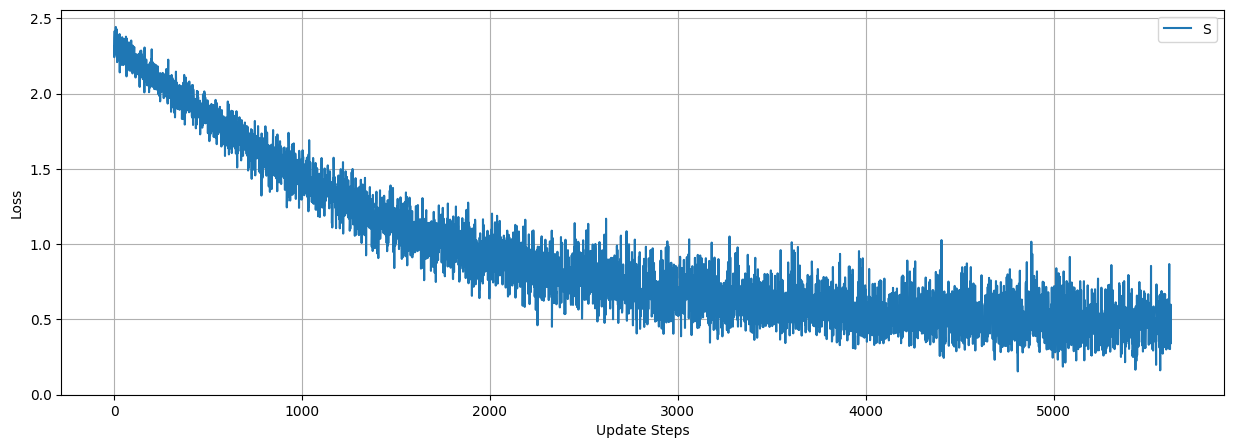

In [200]:
plot_losses([sgd_loss], 'SGD with lr=1e-3')

In [201]:
class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.n_steps = 0
        
    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_grad, avg_sqr_grad in zip(self.model_params, \
                                                 self.avg_grads, \
                                                 self.avg_sqr_grads):
            self.n_steps += 1
            avg_grad.mul_(self.beta_1).add_(param.grad * (1 - self.beta_1))
            avg_sqr_grad.mul_(self.beta_2).add_(param.grad * param.grad * (1 - self.beta_2))
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)
            param.sub_(self.lr * avg_grad_corrected / std)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:14<00:00, 129.89it/s]


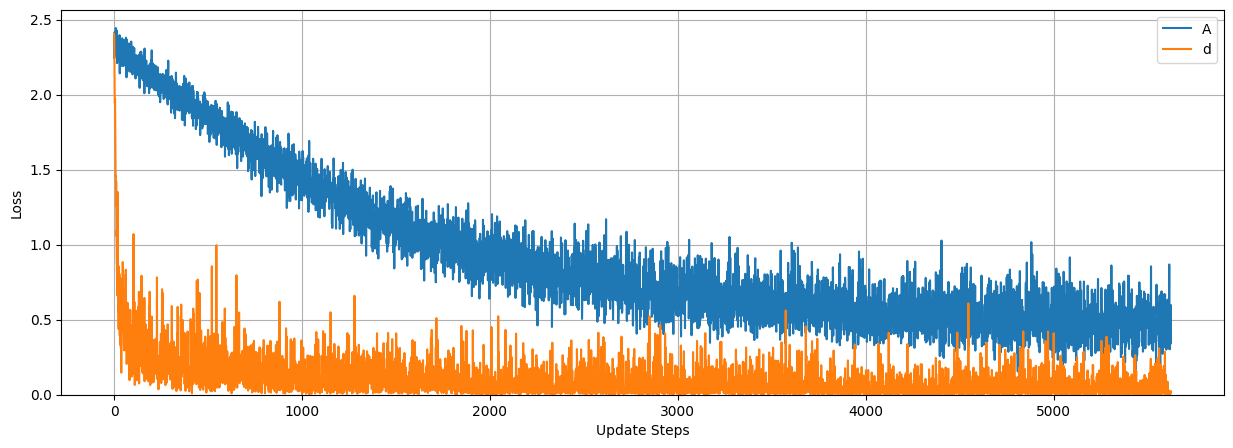

In [202]:
optimizer = Adam(model.parameters())
adam_loss = train(train_iterator, model, optimizer, criterion, device)
plot_losses([sgd_loss, adam_loss], 'Adam with lr=1e-3, betas=(0.9, 0.999), eps=1e-8')

In [ ]:
"""

Momentum:

- Accumulates velocity in direction of persistent gradients
- Intelligently changes size of steps taken
- Takes larger steps in consistent directions
- Accelerates in valleys/slopes of loss surface

RMSprop:

- Divides gradients by moving average of magnitudes
- Intelligently chooses step direction
- Makes steps larger for sparse gradients
- Makes steps smaller for noisy gradients
- Adapts directions based on geometry

So together:

Momentum speeds up SGD by building velocity
RMSprop steers SGD in the right directions via normalized gradients
You can think of momentum as the gas pedal and RMSprop as the steering wheel for gradient descent.

Momentum intelligently changes how fast we move.

RMSprop intelligently changes which direction we move.

Used together, they significantly improve optimization performance compared to vanilla SGD.


"""

In [203]:
class SGD:
    # When this class is instantiated...
    def __init__(self, model_params, lr=1e-3):
        
        # ...a plain old list dicts (the weights!) is saved in the instance
        self.model_params = list(model_params)
        print(len(self.model_params))
        print(type(self.model_params[0]))
        print(self.model_params[0])
        
        # ...and a learning date is saved (0.001 in this case) - WHAT IS LEARNING RATE?
        self.lr = lr

        self.one_step_logged = False
        self.steps_taken = 0

    # A simple method, that sets each of the model parameters "grad" property to None 
    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad() # This is just a pytorch setting: we ask pytorch not to save the 'graph' of mathematical operations - for efficiency 
    def step(self):
        # This is where the magic happens
        for param in self.model_params:
            if not self.one_step_logged:
                print(len(param.grad))
            param.sub_(self.lr * param.grad)
        self.one_step_logged = True
        self.steps_taken += 1

In [204]:
optimizer = SGD(model.parameters())

6
<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([[-0.0119, -0.0538,  0.0331,  ..., -0.0095, -0.0295,  0.0465],
        [ 0.0425, -0.0137, -0.0040,  ..., -0.1032, -0.1097, -0.0169],
        [ 0.0084, -0.0444,  0.0344,  ...,  0.0890, -0.0004,  0.0814],
        ...,
        [-0.0061,  0.0579,  0.0536,  ..., -0.0236,  0.0705, -0.0615],
        [-0.0607,  0.0492,  0.0197,  ..., -0.0120,  0.0599,  0.0494],
        [ 0.0497, -0.0369,  0.0414,  ...,  0.0135, -0.0118, -0.0383]],
       requires_grad=True)


In [205]:
sgd_loss = train(train_iterator, model, optimizer, criterion, device)

  1%|██                                                                                                                                                                                                                   | 18/1875 [00:00<00:10, 178.13it/s]

256
256
256
256
10
10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 190.30it/s]

Steps taken: 5625


In [206]:
#print(train_dataset[0][0])
#print(type(train_dataset[0][0]))

x = [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.1176, 0.1412, 0.3686, 0.6039, 0.6667, 0.9922, 0.9922, 0.9922,
          0.9922, 0.9922, 0.8824, 0.6745, 0.9922, 0.9490, 0.7647, 0.2510,
          0.0000, 0.0000, 0.0000, 0.0000]

print(type(train_dataset))
x = torch.tensor(x).reshape(1, -1)
print(x.shape)

writer = SummaryWriter("torchlogs/")
model = MLP(28, 28*28, 10)
writer.add_graph(model, x)
writer.close()
print("Graph saved - hopefully")

<class 'torchvision.datasets.mnist.MNIST'>
torch.Size([1, 28])
Graph saved - hopefully
